In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
## Display all the columns of the dataframe
import json
import os
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
pd.pandas.set_option('display.max_columns',None)
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [4]:
!pip freeze > requirements.txt

In [3]:
train_flag=pd.read_csv('/Users/adityakadiyan/Downloads/senior_ds_test/data/train/train_flag.csv')

## print shape of dataset with rows and columns
print(train_flag.shape)

(261383, 3)


In [5]:
accounts_data_path = '/Users/adityakadiyan/Downloads/senior_ds_test/data/train/accounts_data_train.json'
enquiry_data_path = '/Users/adityakadiyan/Downloads/senior_ds_test/data/train/enquiry_data_train.json'

In [6]:
def load_json_data(file_path):
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    try:
        with open(file_path, 'r') as file:
            # Load JSON data from the file
            data = json.load(file)
            return data
    except json.JSONDecodeError:
        # Handle JSON decode error (e.g., malformed JSON)
        raise ValueError(f"The file {file_path} is not a valid JSON file.")
    except PermissionError:
        # Handle file permission error
        raise PermissionError(f"Permission denied when trying to read {file_path}.")
    except Exception as e:
        # Handle other potential errors
        raise IOError(f"An error occurred while reading {file_path}: {str(e)}")

In [7]:
accounts_data_dict = load_json_data(accounts_data_path)
enquiry_data_dict = load_json_data(enquiry_data_path)

In [8]:

def convert_to_dataframe(data):

    # Data type validation
    if not isinstance(data, list) or not all(isinstance(inner_list, list) for inner_list in data):
        raise TypeError("Input data must be a list of lists.")

    # Handle empty data
    if not data or not any(data):
        return pd.DataFrame()

    # Flatten the nested list
    flattened_data = []
    for inner_list in data:
        if inner_list:  # Skip empty inner lists
            flattened_data.extend(inner_list)

    # Create DataFrame
    try:
        df = pd.DataFrame(flattened_data)
    except ValueError as ve:
        raise ValueError(f"Error in creating DataFrame: {ve}")

    return df


In [9]:
accounts_data = convert_to_dataframe(accounts_data_dict)
enquiry_data = convert_to_dataframe(enquiry_data_dict)

In [11]:
## dropping duplicates row
accounts_data.drop_duplicates(keep = 'first',inplace = True)
enquiry_data.drop_duplicates(keep = 'first',inplace = True)
train_flag.drop_duplicates(keep = 'first',inplace = True)

In [12]:
features_with_na=[features for features in accounts_data.columns if accounts_data[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(accounts_data[feature].isnull().mean(), 4),  ' % missing values')

loan_amount 0.0  % missing values
closed_date 0.3706  % missing values


In [13]:
features_with_na=[features for features in enquiry_data.columns if enquiry_data[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(enquiry_data[feature].isnull().mean(), 4),  ' % missing values')

In [14]:
features_with_na=[features for features in train_flag.columns if train_flag[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(train_flag[feature].isnull().mean(), 4),  ' % missing values')

# Handling Accounts_data

## Numerical Feature

In [15]:
numerical_features = [feature for feature in accounts_data.columns if accounts_data[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

Number of numerical variables:  2


In [16]:
discrete_feature=[feature for feature in numerical_features if len(accounts_data[feature].unique())<25 ]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 0


In [17]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print("Continuous feature Count {}".format(len(continuous_feature)))

Continuous feature Count 2


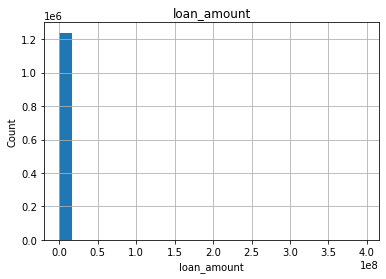

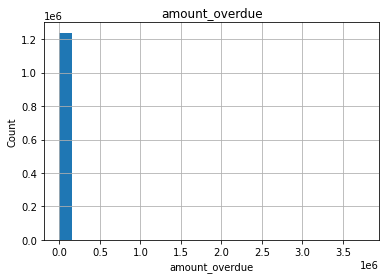

In [18]:
for feature in continuous_feature:
    data=accounts_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

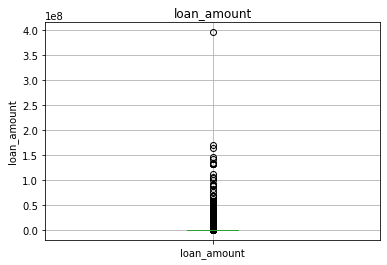

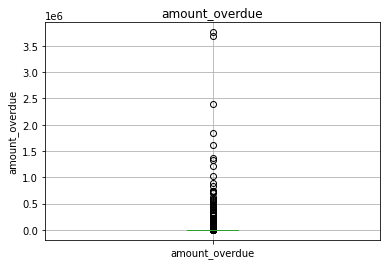

In [19]:
for feature in continuous_feature:
    data=accounts_data.copy()
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

In [20]:
accounts_data['loan_amount_log'] = np.log(accounts_data['loan_amount'] + 1)
accounts_data['amount_overdue_log'] = np.log(accounts_data['amount_overdue'] + 1)

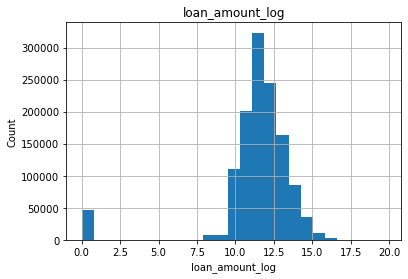

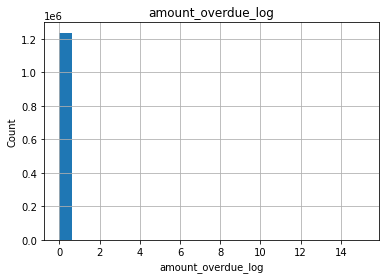

In [21]:
for feature in ['loan_amount_log','amount_overdue_log']:
    data=accounts_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [24]:
def take_log(data , cols):
    try:
        for col in cols:
            col_name = col+'_log'
            data[col_name] = np.log(data[col] + 1)
        return data
    except KeyError as e:
        raise KeyError(f"Column not found: {e}")
    except Exception as e:
        raise Exception(f"Error in logarithmic transformation: {e}")
    

In [25]:
def iqr_process(data , cols):
    # Remove outliers
    try:
        for col in cols:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            data = data[~((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR)))]
        return data
    except Exception as e:
        raise Exception(f"Error in outlier removal: {e}")

In [26]:
def process_account_data(accounts_data):
    # Input validation
    if not isinstance(accounts_data, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    # Check for required columns
    required_columns = ['loan_amount', 'amount_overdue', 'payment_hist_string', 'closed_date']
    missing_columns = [col for col in required_columns if col not in accounts_data.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    # Logarithmic transformation with error handling
    #accounts_data = take_log(accounts_data , ['loan_amount','amount_overdue'])
    # Remove closed loans with specific conditions
    accounts_data = iqr_process(accounts_data , ['loan_amount_log'])
    try:
        accounts_data = accounts_data[~((accounts_data['payment_hist_string'].str.replace('0', '') == '') &
                                        (accounts_data['amount_overdue'] > 0) & 
                                        accounts_data['closed_date'].notna())]
    except KeyError as e:
        raise KeyError(f"Column not found: {e}")
    except Exception as e:
        raise Exception(f"Error in filtering closed loans: {e}")

    return accounts_data


In [27]:
# ## remove closed loans which have overdue amount but they always paid on time
accounts_data = process_account_data(accounts_data)

In [31]:
accounts_data = accounts_data.drop(['loan_amount_log','amount_overdue_log'],axis =1)

In [32]:
def extract_features(payment_hist, uid):
    # Data type validation
    if not isinstance(payment_hist, str):
        raise TypeError("payment_hist must be a string.")
    
    # Check if pandas is available
    if 'pd' not in globals():
        raise ImportError("pandas library is not imported.")

    # Convert payment history to integers with error handling
    try:
        payments = [int(payment_hist[i:i+3]) for i in range(0, len(payment_hist), 3)][::-1] if payment_hist else [0]
    except ValueError:
        raise ValueError("payment_hist contains non-numeric values.")

    total_payments = len(payments)
    late_payments = sum(p > 0 for p in payments)

    # Calculate features
    try:
        return {
            'uid': uid,
            'recent_delinquency': payments[0],
            'max_delinquency': max(payments),
            'avg_delinquency': sum(payments) / total_payments if total_payments else 0,
            'late_payments': late_payments,
            'consecutive_ontime_payments': next((i for i, p in enumerate(payments) if p > 0), total_payments),
            'total_payments': total_payments,
            'zero_delinquency_months': sum(p == 0 for p in payments),
            'late_payment_proportion': late_payments / total_payments if total_payments else 0,
            'delinquency_std_dev': pd.Series(payments).std() if total_payments > 1 else 0
        }
    except Exception as e:
        raise Exception(f"Error calculating features: {e}")



In [33]:
num_cores = 4  # Adjust based on your machine's capabilities
results = Parallel(n_jobs=num_cores)(delayed(extract_features)(
    row.payment_hist_string, row.uid) for index, row in accounts_data.iterrows())



In [34]:
features_df = pd.DataFrame(results)

In [35]:

def aggregate_data(df, groupby_column, agg_dict):

    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    # Check for the existence of the groupby column
    if groupby_column not in df.columns:
        raise ValueError(f"The groupby column '{groupby_column}' does not exist in the DataFrame.")

    # Check for the existence of the columns specified in agg_dict
    missing_columns = [col for col in agg_dict if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns for aggregation: {missing_columns}")

    # Aggregation with error handling
    try:
        agg_data = df.groupby(groupby_column).agg(agg_dict).reset_index()
    except Exception as e:
        raise Exception(f"Error during aggregation: {e}")

    return agg_data


In [36]:
payment_hist_features = {
    'recent_delinquency': ['mean','median', 'max', 'min'],
    'max_delinquency': ['mean','median', 'max', 'min'],
    'avg_delinquency': ['mean','median'],
    'late_payments': ['sum','median', 'mean'],
    'consecutive_ontime_payments': ['mean','median', 'max', 'min'],
    'total_payments': ['sum', 'median','mean'],
    'zero_delinquency_months': ['sum', 'median','mean'],
    'late_payment_proportion': ['mean','median'],
    'delinquency_std_dev': ['mean','median']
}

In [37]:
agg_payment_data = aggregate_data(features_df, 'uid',payment_hist_features)

In [38]:
agg_user_data = agg_payment_data

In [41]:
agg_accounts_data = accounts_data.groupby('uid')['credit_type'].value_counts().unstack(fill_value=0)
agg_accounts_data.columns = [f'credit_type_count_{col}' for col in agg_accounts_data.columns]

In [42]:
columns_from_training = agg_accounts_data.columns

# Save to a file
columns_from_training.to_series().to_csv('/Users/adityakadiyan/Desktop/monsoon_credit/training_columns.csv', index=False)

In [43]:
loan_data_features = {
    'loan_amount': ['sum', 'median','mean', 'max', 'min', 'count'],
}

In [44]:
agg_loan_data = aggregate_data(accounts_data, 'uid',loan_data_features)

In [45]:
# Merging the loan amount data with the credit type data
agg_accounts_data = pd.merge(agg_accounts_data, agg_loan_data, on='uid', how='left')

/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/179599844.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  agg_accounts_data = pd.merge(agg_accounts_data, agg_loan_data, on='uid', how='left')
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [49]:
amount_overdue_features = {
    'amount_overdue': ['sum','median', 'mean', 'max', (lambda x: (x > 0).sum()), (lambda x: (x > 0).mean())]
}

In [50]:
agg_overdue_data = aggregate_data(accounts_data, 'uid',amount_overdue_features)

In [51]:
agg_accounts_data = pd.merge(agg_accounts_data, agg_overdue_data, on='uid', how='left')

/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/2645993703.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  agg_accounts_data = pd.merge(agg_accounts_data, agg_overdue_data, on='uid', how='left')
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [52]:
agg_user_data = pd.merge(agg_accounts_data, agg_user_data, on='uid', how='left')

/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/349839158.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  agg_user_data = pd.merge(agg_accounts_data, agg_user_data, on='uid', how='left')


In [53]:
agg_user_data.shape

(222402, 54)

In [54]:
def determine_active_status(accounts_data):
    if 'closed_date' not in accounts_data.columns:
        raise ValueError("Missing 'closed_date' column in DataFrame.")
    
    accounts_data['is_active'] = accounts_data['closed_date'].isna()
    return accounts_data


In [55]:
def handle_dates_and_holidays(accounts_data):
    if not all(col in accounts_data.columns for col in ['open_date', 'closed_date']):
        raise ValueError("Missing 'open_date' or 'closed_date' columns in DataFrame.")

    accounts_data['open_date'] = pd.to_datetime(accounts_data['open_date'])
    accounts_data['closed_date'] = pd.to_datetime(accounts_data['closed_date'])

    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=accounts_data['open_date'].min(), end=accounts_data['closed_date'].max())

    accounts_data['opened_on_holiday'] = accounts_data['open_date'].isin(holidays)
    accounts_data['closed_on_holiday'] = accounts_data['closed_date'].isin(holidays)

    return accounts_data

In [56]:
def calculate_loan_duration(accounts_data):
    if not all(col in accounts_data.columns for col in ['open_date', 'is_active']):
        raise ValueError("Missing required columns in DataFrame.")

    today = datetime.today()
    accounts_data['loan_duration'] = accounts_data.apply(
        lambda row: (row['closed_date'] if not row['is_active'] else today) - row['open_date'], axis=1)

    accounts_data['loan_duration'] = accounts_data['loan_duration'].dt.days
    accounts_data = accounts_data[accounts_data['loan_duration'] >= 0]

    return accounts_data

In [57]:
def add_date_related_features(accounts_data):
    if 'open_date' not in accounts_data.columns:
        raise ValueError("Missing 'open_date' column in DataFrame.")

    today = datetime.today()
    accounts_data['time_since_opened'] = (today - accounts_data['open_date']).dt.days

    accounts_data['open_month'] = accounts_data['open_date'].dt.month
    accounts_data['open_quarter'] = accounts_data['open_date'].dt.quarter
    accounts_data['open_year'] = accounts_data['open_date'].dt.year
    accounts_data['opened_on_weekend'] = accounts_data['open_date'].dt.weekday > 4
    return accounts_data


In [58]:
def process_accounts_data(accounts_data):
    accounts_data = determine_active_status(accounts_data)
    accounts_data = handle_dates_and_holidays(accounts_data)
    accounts_data = calculate_loan_duration(accounts_data)
    accounts_data = add_date_related_features(accounts_data)
    return accounts_data


In [59]:
accounts_data = process_accounts_data(accounts_data)

/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/2032305639.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_data['time_since_opened'] = (today - accounts_data['open_date']).dt.days
/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/2032305639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accounts_data['open_month'] = accounts_data['open_date'].dt.month
/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/2032305639.py:9: SettingWithCopyWarning: 
A

In [60]:
date_features = {
    'is_active': 'sum',
    'opened_on_holiday': 'sum',
    'closed_on_holiday': 'sum',
    'loan_duration': ['mean', 'sum', 'max'],
    'time_since_opened': ['mean', 'max'],
    'open_month': lambda x: x.mode()[0],
    'open_quarter': lambda x: x.mode()[0],
    'open_year': lambda x: x.mode()[0],
    'opened_on_weekend': 'sum'
}

In [61]:
agg_date_data = aggregate_data(accounts_data, 'uid',date_features)

In [62]:
agg_user_data = pd.merge(agg_user_data, agg_date_data, on='uid', how='left')

/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/328809343.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  agg_user_data = pd.merge(agg_user_data, agg_date_data, on='uid', how='left')
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [63]:
agg_user_data.shape

(222402, 66)

# Enquiry Data

In [64]:
numerical_features = [feature for feature in enquiry_data.columns if enquiry_data[feature].dtypes != 'O']
print('Number of numerical variables: ', len(numerical_features))

Number of numerical variables:  1


In [65]:
discrete_feature=[feature for feature in numerical_features if len(enquiry_data[feature].unique())<25 ]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 0


In [66]:
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print("Continuous feature Count {}".format(len(continuous_feature)))

Continuous feature Count 1


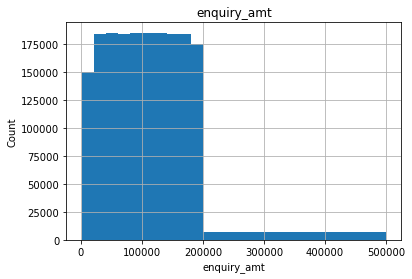

In [67]:
for feature in continuous_feature:
    data=enquiry_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

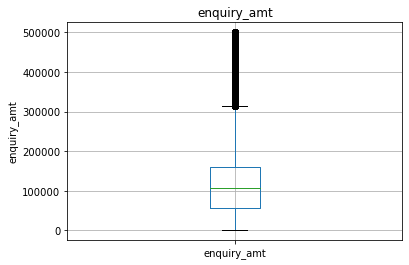

In [68]:
for feature in continuous_feature:
    data=enquiry_data.copy()
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

In [69]:
enquiry_data['enquiry_amt_log'] = np.log(enquiry_data['enquiry_amt'] + 1)


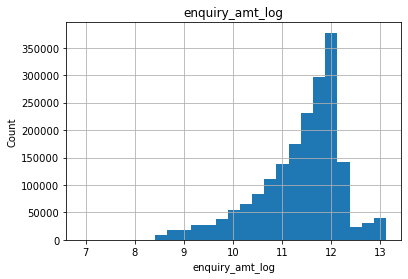

In [70]:
for feature in ['enquiry_amt_log']:
    data=enquiry_data.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

## Categorical Variables

In [71]:
categorical_features=[feature for feature in enquiry_data.columns if enquiry_data[feature].dtypes=='O']


In [72]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(enquiry_data[feature].unique())))

The feature is enquiry_type and number of categories are 17
The feature is enquiry_date and number of categories are 1776
The feature is uid and number of categories are 261383


In [73]:
agg_enquiry_type_data = enquiry_data.groupby('uid')['enquiry_type'].value_counts().unstack(fill_value=0)
agg_enquiry_type_data.columns = [f'enquiry_type_count_{col}' for col in agg_enquiry_type_data.columns]

In [74]:
enquiry_amt_features = {
    'enquiry_amt': ['sum', 'median','mean', 'max', 'min', 'count'],
}

In [75]:
agg_amt_data = aggregate_data(enquiry_data, 'uid',enquiry_amt_features)

In [76]:
# Merging the loan amount data with the credit type data
agg_enquiry_type_data = pd.merge(agg_enquiry_type_data, agg_amt_data, on='uid', how='left')

/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/1364901562.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  agg_enquiry_type_data = pd.merge(agg_enquiry_type_data, agg_amt_data, on='uid', how='left')
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [77]:
agg_enquiry_type_data.shape

(261383, 24)

In [78]:
def process_enquiry_data(enquiry_data):
    # Input validation
    if not isinstance(enquiry_data, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    # Check for the existence of the enquiry_date column
    if 'enquiry_date' not in enquiry_data.columns:
        raise ValueError("Missing 'enquiry_date' column in DataFrame.")

    try:
        # Convert enquiry_date to datetime
        enquiry_data['enquiry_date'] = pd.to_datetime(enquiry_data['enquiry_date'])

        # Calculate days since enquiry
        today = datetime.today()
        enquiry_data['days_since_enquiry'] = (today - enquiry_data['enquiry_date']).dt.days

        # Extract month, quarter, and year
        enquiry_data['enquiry_month'] = enquiry_data['enquiry_date'].dt.month
        enquiry_data['enquiry_quarter'] = enquiry_data['enquiry_date'].dt.quarter
        enquiry_data['enquiry_year'] = enquiry_data['enquiry_date'].dt.year

        # Determine if the enquiry was made on a weekend
        enquiry_data['enquiry_on_weekend'] = enquiry_data['enquiry_date'].dt.weekday > 4

        # Handle potential negative days (future dates)
        if enquiry_data['days_since_enquiry'].min() < 0:
            raise ValueError("Enquiry data contains future dates.")
    except Exception as e:
        raise Exception(f"Error processing enquiry data: {e}")

    return enquiry_data


In [79]:
enquiry_data = process_enquiry_data(enquiry_data)

In [80]:
enquiry_date_features = {
    'days_since_enquiry_time': ['mean', 'max'],
    'enquiry_month': lambda x: x.mode()[0],
    'enquiry_quarter': lambda x: x.mode()[0],
    'enquiry_year': lambda x: x.mode()[0],
    'enquiry_on_weekend': 'sum'
}

In [81]:
agg_enquiry_date_data = aggregate_data(enquiry_data, 'uid',enquiry_amt_features)

In [82]:
agg_enquiry_type_data = pd.merge(agg_enquiry_type_data, agg_enquiry_date_data, on='uid', how='left')

/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/2448534338.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  agg_enquiry_type_data = pd.merge(agg_enquiry_type_data, agg_enquiry_date_data, on='uid', how='left')


In [83]:
agg_uids_history = pd.merge(agg_enquiry_type_data,agg_user_data,on='uid', how = 'left').fillna(0)

In [87]:
train_flag = pd.merge(train_flag,agg_uids_history ,on = 'uid', how = 'left' )

In [90]:
train_flag.columns = [str(col) for col in train_flag.columns]


In [116]:
train_flag.columns = train_flag.columns.astype(str).str.replace(
    '[', '').str.replace(']', '').str.replace('<', '').str.replace('>', '').str.replace(
    '(', '').str.replace(')', '').str.replace('"', '').str.replace("'", '').str.replace(
    ',', '_').str.replace('lambda', '').str.replace(' ', '_')

/var/folders/tc/w74lvrns7m5445v0b2rsg0v80000gn/T/ipykernel_58402/2964543600.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_flag.columns = train_flag.columns.astype(str).str.replace(


In [108]:
columns_from_training = train_flag.columns

# Save to a file
columns_from_training.to_series().to_csv('/Users/adityakadiyan/Desktop/monsoon_credit/final_columns.csv', index=False)


## feature selection

In [81]:
X = train_flag.drop(['uid', 'TARGET'], axis=1)
y = train_flag['TARGET']

In [82]:
chi2_selector = SelectKBest(chi2, k='all')  # Change k to the number of features you want to select
chi2_selector.fit(X, y)

chi_scores = chi2_selector.scores_

In [83]:
# Create a DataFrame to view scores and features
p_values = pd.DataFrame()
p_values['feature'] = X.columns
p_values['chi2_score'] = chi_scores
p_values['p_value'] = chi2_selector.pvalues_

In [91]:
p_values.sort_values(by='chi2_score', ascending=False, inplace=True)

# Display the results

features_to_keep = list(p_values[p_values['p_value'] > 0.001]['feature'])

# Filter your encoded DataFrame to keep only these features
train_filtered = train_flag[['uid', 'TARGET']+features_to_keep]

In [77]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [105]:
X = train_flag.drop(['uid', 'TARGET'], axis=1)
y = train_flag['TARGET']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

In [ ]:
estimator = RandomForestClassifier(n_estimators=100, max_depth=20, class_weight='balanced', 
                                max_features=30, random_state=42, n_jobs=-1)
selector = RFECV(estimator, step=5, cv=10, n_jobs=-1)
selector = selector.fit(X_train, y_train)

In [ ]:
selected_features = pd.DataFrame({'Feature': list(X.columns),
                                  'Support': selector.support_,
                                  'Ranking': selector.ranking_})
print(selected_features.sort_values(by='Ranking'))

In [ ]:
features_to_keep = list(p_values[p_values['p_value'] > 0.001]['feature'])

# Filter your encoded DataFrame to keep only these features
train_filtered = train_flag[['uid', 'TARGET']+features_to_keep]


In [137]:
train_filtered.columns

Index(['uid', 'TARGET', 'NAME_CONTRACT_TYPE_Cash loans',
       'NAME_CONTRACT_TYPE_Revolving loans',
       'enquiry_type_count_Another type of loan',
       'enquiry_type_count_Car loan',
       'enquiry_type_count_Cash loan non-earmarked',
       'enquiry_type_count_Cash loans', 'enquiry_type_count_Consumer credit',
       'enquiry_type_count_Credit card', 'enquiry_type_count_Interbank credit',
       'enquiry_type_count_Loan for business development',
       'enquiry_type_count_Loan for purchase of shares margin lending',
       'enquiry_type_count_Loan for the purchase of equipment',
       'enquiry_type_count_Loan for working capital replenishment',
       'enquiry_type_count_Microloan',
       'enquiry_type_count_Mobile operator loan',
       'enquiry_type_count_Mortgage', 'enquiry_type_count_Real estate loan',
       'enquiry_type_count_Revolving loans',
       'enquiry_type_count_Unknown type of loan', 'sum', 'median', 'mean',
       'max', 'min_x', 'count_x', 'days_since_enqu

## models

In [95]:
X = train_filtered.drop(['uid', 'TARGET'], axis=1)
y = train_filtered['TARGET']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
param_grids = {
    'RandomForest': {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']},  # As per above suggestions
    'AdaBoost': {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 1],
    'algorithm': ['SAMME', 'SAMME.R']},
    'XGBoost': {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10, 15],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [(len(y) - sum(y)) / sum(y)] # Adjust for imbalance
}

}

In [100]:
models = { 
    'RandomForest': RandomForestClassifier,
    'XGBoost': XGBClassifier ,
    'AdaBoost': AdaBoostClassifier   
}


In [101]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [102]:
best_models = {}

In [103]:
import itertools

In [ ]:
for model_name, model_class in models.items():
    keys, values = zip(*param_grids[model_name].items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    best_roc_auc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        model = model_class(**params)
        roc_auc_scores = []

        for train_index, test_index in stratified_kfold.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            model.fit(X_train_fold, y_train_fold)
            y_pred_fold = model.predict_proba(X_test_fold)[:, 1]
            roc_auc_fold = roc_auc_score(y_test_fold, y_pred_fold)
            roc_auc_scores.append(roc_auc_fold)

        avg_roc_auc = np.mean(roc_auc_scores)
        print(f"ROC AUC for {model_name} with params {params}: {avg_roc_auc}")

        if avg_roc_auc > best_roc_auc:
            best_roc_auc = avg_roc_auc
            best_params = params
            best_model = model

    best_models[model_name] = {'model': best_model, 'params': best_params, 'roc_auc': best_roc_auc}


In [179]:
X = train_filtered.drop(['uid', 'TARGET'], axis=1)
y = train_filtered['TARGET']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [171]:
best_models

{'RandomForest': {'model': sklearn.ensemble._forest.RandomForestClassifier,
  'params': {'n_estimators': 200,
   'max_depth': 20,
   'min_samples_split': 10,
   'min_samples_leaf': 4,
   'bootstrap': True,
   'class_weight': 'balanced'},
  'roc_auc': 0.6683215343453454},
 'AdaBoost': {'model': sklearn.ensemble._weight_boosting.AdaBoostClassifier,
  'params': {'n_estimators': 50, 'learning_rate': 0.01, 'algorithm': 'SAMME'},
  'roc_auc': 0.6123246890429814},
 'XGBoost': {'model': xgboost.sklearn.XGBClassifier,
  'params': {'n_estimators': 200,
   'learning_rate': 0.05,
   'max_depth': 10,
   'subsample': 0.5,
   'colsample_bytree': 0.5,
   'scale_pos_weight': 11.41311677826851},
  'roc_auc': 0.683419481490242}}

In [181]:
xgboost_params = best_models['XGBoost']['params']
xgboost_model_class = best_models['XGBoost']['model']

In [182]:
final_model = xgboost_model_class(**xgboost_params)

In [183]:
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [184]:
y_pred_proba = final_model.predict_proba(X_test)[:, 1]


In [186]:
final_model.save_model('/Users/adityakadiyan/Desktop/monsoon_credit/my_xgboost_model.json')

In [192]:
model_feature_names = final_model.get_booster().feature_names

In [193]:
folder_path = '/Users/adityakadiyan/Desktop/monsoon_credit/'  # Replace with your folder path

# Create the directory if it does not exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# File path
file_path = os.path.join(folder_path, 'model_feature_names.txt')

# Write the list to a file
with open(file_path, 'w') as file:
    for item in model_feature_names:
        file.write("%s\n" % item)